Import Dependencies

In [1]:
import pandas as pd
import numpy as np

## Load Dataset

Movie Review

In [29]:
import os
from eraserbenchmark.rationale_benchmark.utils import load_documents, load_datasets, annotations_from_jsonl, Annotation

data_root = os.path.join('eraserbenchmark/data', 'movies')
documents = load_documents(data_root)
train, val, test = load_datasets(data_root)

In [44]:
data_raw = train[5]
data_raw.__dict__

{'annotation_id': 'negR_005.txt',
 'query': 'What is the sentiment of this review?',
 'evidences': frozenset({(Evidence(text='also unimpressive', docid='negR_005.txt', start_token=631, end_token=633, start_sentence=30, end_sentence=31),),
            (Evidence(text='it is a very bad mistake to make', docid='negR_005.txt', start_token=107, end_token=115, start_sentence=6, end_sentence=7),),
            (Evidence(text='sadly what follows is not really up to the buildup', docid='negR_005.txt', start_token=549, end_token=559, start_sentence=26, end_sentence=27),),
            (Evidence(text='tacky looking rundown martian mining colony', docid='negR_005.txt', start_token=405, end_token=411, start_sentence=19, end_sentence=20),),
            (Evidence(text='that still does not make for a really good science fiction experience', docid='negR_005.txt', start_token=218, end_token=230, start_sentence=11, end_sentence=12),),
            (Evidence(text='these are standard haunted house film shock e

In [30]:
import string
def obtain_text_review(data_raw, documents, token_length=256):
    word_list = [word for sent in documents[data_raw.annotation_id][:token_length] for word in sent+["\n"]][:token_length]
    word_list_refined = [" "+word if word not in string.punctuation else word for word in word_list ]
    paragraph = "".join(word_list_refined)[1:]
    return paragraph

from collections import Counter
data_split = train
token_length = 1000
label_types = {'POS':'positive', 'NEG':'negative'}

df = pd.DataFrame(columns=['review', 'label'])
for data_raw in data_split:
    review = obtain_text_review(data_raw, documents, token_length)
    label = data_raw.classification
    df.loc[len(df)] = [review, label_types[label]]

counts = df['label'].value_counts()
counts

negative    800
positive    800
Name: label, dtype: int64

## Get Explanations

### GPT explanation

In [32]:
# imports
import os
import ast  # for converting embeddings saved as strings back to arrays
import openai  
import pandas as pd
import tiktoken  # for counting tokens
from tqdm.auto import tqdm
from scipy import spatial  # for calculating vector similarities for search
openai.api_key = os.environ["OPENAI_API_KEY"]

# models
EMBEDDING_MODEL = "text-embedding-ada-002"
# GPT_MODEL = "gpt-3.5-turbo"
GPT_MODEL = "gpt-4-0613" # According to OpenAI, GPT-4 is more responsive to system messages, whereas 3.5 would rely on more of the user input.


In [35]:
def summarize(input_premise, is_query=False, n_reviews=None):
    if is_query:
        query = input_premise
        n_reviews = n_reviews
    else:
        query = []
        for x in input_premise:
            query.append(f">>>Review starts\n{x}\n>>>Review ends\n")
        query = "\n".join(query)
        n_reviews = len(input_premise)
    # Please shorten each of the following movie reivews in between 48-96 words in the tone of the reviewer while trying to preserve its meanings.

    sys_msg = f"""
    Please extract the opinions and rewrite the following movie reviews pretending you are the original reviewer, each in about 32 words. 
    Note: Treat each review independently. The start and end of an review is marked by ">>>Review starts" and ">>>Review ends".

    Reply in the following format: 
    The response to each review contains 1 line, which is the shortened version of the review.
    If there are more than 2 reviews, the replies should be are serparated by a new line of "---".
    
    If you feel impossible to summary, please put "I can't summary this review" at the corresponding line.
    The followings are examples of valid replies:
    
    your summary 1
    ---
    I can't summary this review
    ---
    your summary 3
    """

    response = openai.ChatCompletion.create(
            messages=[
                {'role': 'system', 'content': sys_msg},
                {'role': 'user', 'content': query},
            ],
            model=GPT_MODEL,
            temperature=0,
        )

    model_response = response['choices'][0]['message']['content']
    reply_counts = model_response.count("\n---")
    try:
        assert reply_counts+1 == n_reviews
    except AssertionError:
        print(">>>>>>>>>>>>AssertionError:")
        print(f"number of replies {reply_counts+1} does not match number of reviews {n_reviews}")
        print(query)
        print(model_response)
        raise AssertionError
    summarized_reviews = model_response.split("\n---\n")
    return summarized_reviews

summaries_list = []
batch_size = 5
sample_size = 120

new_df = df[:sample_size].copy().reset_index(drop=True)
for i in tqdm(range(0, sample_size, batch_size)):
    summaries_list.extend(summarize(df.review[i:i+batch_size]))
new_df['review'] = summaries_list
new_df.to_csv(f'movies_{sample_size}.csv', index=False)

In [22]:
summaries_list

["The movie is a mind-bending teen flick with a cool concept but poor execution. It's too jumbled and confusing, with too many unexplained elements. Despite a cool ending, it's not engaging or entertaining.",
 '"Virus" is a flashy but empty action movie. The plot is unclear, the acting is subpar, and the characters are uninteresting. The only redeeming qualities are the robot design and gore effects.',
 '"The Mod Squad" is a dull, clichéd movie with wooden acting and a predictable plot. It\'s a poor adaptation of the 1960s TV show, with no suspense or interesting characters. Avoid at all costs.',
 '"Quest for Camelot" is a dull, bland, and forgettable attempt by Warner Bros. to compete with Disney. It lacks showmanship, interesting characters, and memorable songs. It\'s a personality-less movie that fails to entertain.',
 '"Stalked" is a clichéd, predictable, and somewhat boring thriller. The acting is adequate but the plot is contrived and the suspense is lacking. It\'s not offensive,

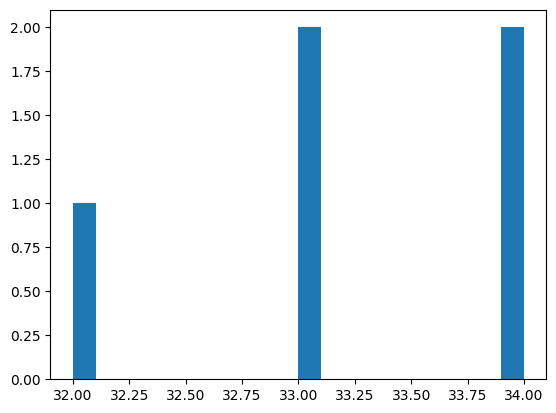

In [23]:
wc = [len(x.split(' ')) for x in summaries_list]
import matplotlib.pyplot as plt
plt.hist(wc, bins=20)
plt.show()

In [25]:
# an example nle question
choices = ['positive', 'negative']

def prediction_function(input_premise, is_query=False, n_reviews=None):
    if is_query:
        query = input_premise
        n_reviews = n_reviews
    else:
        query = []
        for i, x in enumerate(input_premise):
            query.append(f">>>Review {i} starts\n{x}\n>>>Review {i} ends\n")
        query = "".join(query)
        n_reviews = len(input_premise)
    # print(query)
    sys_msg = f"""
    What is the sentiment of the following reviews?
    For each review, provide the probabilities of each choices from {choices} and explain your reasoning.
    Note: Treat each review independently. The start and end of an review is marked by ">>>Review i starts" and ">>>Review i ends" where i is the number. The notion "[MASK]" means a missing word.

    Reply in the following format: 
    The reply to each review contains 3 lines.
    The first line contains the probabilities of each choice seperated by a space,
    and the second line is the explanation, which should not contain any special character.
    The third line is a seperator "---" marking the end of the reply.
    There should be no new line between consecutive replies.
    
    If you cannot decide, please still guess a probability for each choice and explain why you cannot decide.
    The followings are examples of a valid response taht contains 4 replies, followed by 4 lines of "---":
    0.15 0.85
    your explanation
    ---
    0.5 0.5
    your explanation
    ---
    0.68 0.32
    your explanation
    ---
    0.71 0.29
    your explanation
    ---
    """

    response = openai.ChatCompletion.create(
        messages=[
            {'role': 'system', 'content': sys_msg},
            {'role': 'user', 'content': query},
        ],
        model=GPT_MODEL,
        temperature=0,
    )

    model_response = response['choices'][0]['message']['content']
    reply_counts = model_response.count("\n---")
    try:
        assert reply_counts == n_reviews
    except AssertionError:
        print(">>>>>>>>>>>>AssertionError:")
        print(f"number of replies {reply_counts} does not match number of reviews {n_reviews}")
        print(query)
        print(model_response)
        raise AssertionError

    y_prob_list, model_nle_list = [], []
    model_response += '\n'
    for line in model_response.split("\n---\n")[:-1]:
        try:
            y_prob, model_nle = line.split('\n')
            y_prob = [float(p) for p in y_prob.split(' ')]
            y_prob_list.append(y_prob)
            model_nle_list.append(model_nle)
        except:
            print(">>>>>>>>>>>>Exception: model reply in wrong format for one reply")
            print(query)
            print(model_response)
            # y_prob_list.append([0.5, 0.5])
            # model_nle_list.append("Unknown")
            raise AssertionError
    return y_prob_list, model_nle_list

# SHAP_function("I love this movie, but I don't like the ending. Still it is a good movie.")
# SHAP_function("I ? this movie, but I don't ? the ending. Still it is a ? movie.")
# SHAP_function(df.review[5])
import scipy as sp

def f(x, batch_size=10):
    outputs = []
    for i in range(0,len(x),batch_size):
        _x = x[i:i+batch_size]
        success = False
        for i in range(5):
            try:
                y_prob_list, _ = prediction_function(_x)
                success = True
                break
            except AssertionError:
                print("retrying")
                continue
        if success == False:
            raise AssertionError("model reply in wrong format")
        outputs.extend(y_prob_list)
    outputs = np.array(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val


import tiktoken
import shap
from functools import partial
from tqdm.auto import tqdm
from IPython.display import clear_output

class tokenizer:
    def __init__(self) -> None:
        self.tokenizer = tiktoken.encoding_for_model("gpt-4-0613")
    def __call__(self, x):
        return {"input_ids":self.tokenizer.encode(x)}
    def decode(self, x):
        return self.tokenizer.decode(x)

tok = tokenizer()
shap_tok = shap.maskers.Text(tok, mask_token='[MASK]', collapse_mask_token=False)

shap_value_list, y_prob_list, model_nle_list = [], [], []
for i in tqdm(range(1)):
    current_review_summary = summaries_list[i]
    clear_output(wait=True)
    explainer = shap.Explainer(partial(f, batch_size=8), masker=shap_tok, output_names=choices)
    y_prob_sub_list, model_nle_sub_list = prediction_function([current_review_summary])
    y_prob_list.extend(y_prob_sub_list)
    model_nle_list.extend(model_nle_sub_list)
    # shap_values = explainer([current_review_summary], max_evals=64)
    shap_values = explainer([current_review_summary], batch_size=8, max_evals=64)
    shap_value_list.append(shap_values)
# f(["This book is pretty interesting but it's too long", "This book is pretty interesting but it's too [MASK]"])

  0%|          | 0/62 [00:00<?, ?it/s]

Partition explainer: 2it [02:33, 153.20s/it]              


In [26]:
shap_values

shap.plots.text(shap_values)

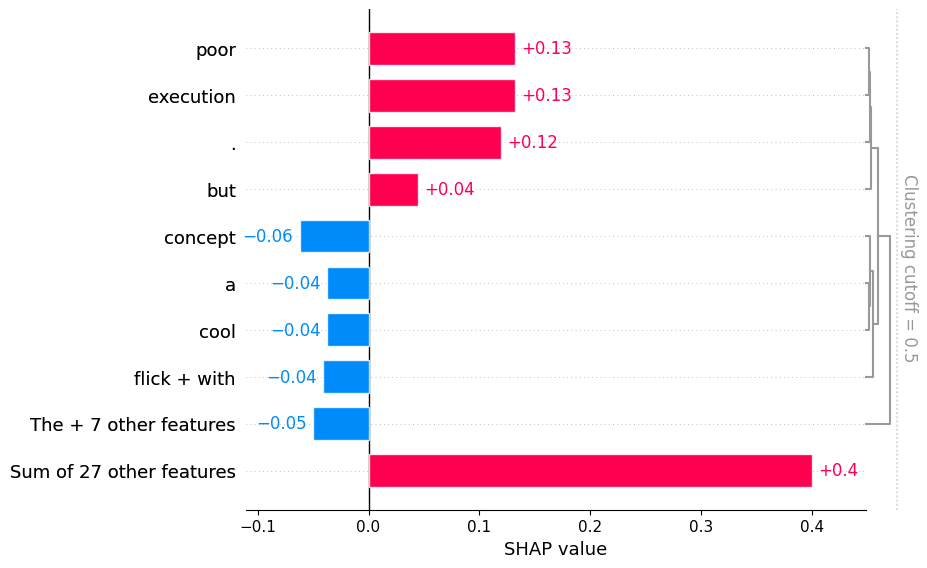

In [27]:
shap.plots.bar(shap_values[0,:,'negative'])

## Obtain NLE Embeddings

In [ ]:
import torch
roberta = torch.hub.load('pytorch/fairseq', 'roberta.large', verbose=0)
roberta.eval()  # disable dropout (or leave in train mode to finetune)
roberta.to('cuda')

In [27]:
to_tok = list(df_cose.columns)
for x in ['id', 'label']:
    to_tok.remove(x)
tok_df_cose = df_cose.copy()
tok_df_cose[to_tok] = tok_df_cose[to_tok].apply(lambda x: [roberta.encode(str(s)) for s in x])
tok_df_cose

,id,question,choice_0,choice_1,choice_2,choice_3,choice_4,label,human_expl_open-ended
0,075e483d21c29a511267ef62bedc0461,"[tensor(0), tensor(133), tensor(2637), tensor(...","[tensor(0), tensor(47072), tensor(2)]","[tensor(0), tensor(225), tensor(9091), tensor(2)]","[tensor(0), tensor(11515), tensor(20444), tens...","[tensor(0), tensor(219), tensor(1641), tensor(...","[tensor(0), tensor(40623), tensor(2)]",0,"[tensor(0), tensor(7199), tensor(686), tensor(..."
1,61fe6e879ff18686d7552425a36344c8,"[tensor(0), tensor(21169), tensor(4783), tenso...","[tensor(0), tensor(12326), tensor(1349), tenso...","[tensor(0), tensor(15076), tensor(12944), tens...","[tensor(0), tensor(627), tensor(10348), tensor...","[tensor(0), tensor(1115), tensor(27699), tenso...","[tensor(0), tensor(14288), tensor(16776), tens...",1,"[tensor(0), tensor(4763), tensor(40), tensor(2..."
2,02e821a3e53cb320790950aab4489e85,"[tensor(0), tensor(20441), tensor(21089), tens...","[tensor(0), tensor(33557), tensor(982), tensor...","[tensor(0), tensor(119), tensor(3463), tensor(...","[tensor(0), tensor(12659), tensor(3730), tenso...","[tensor(0), tensor(415), tensor(15086), tensor...","[tensor(0), tensor(139), tensor(26705), tensor...",3,"[tensor(0), tensor(35887), tensor(9354), tenso..."
3,23505889b94e880c3e89cff4ba119860,"[tensor(0), tensor(133), tensor(23602), tensor...","[tensor(0), tensor(28674), tensor(7716), tenso...","[tensor(0), tensor(2457), tensor(790), tensor(2)]","[tensor(0), tensor(25270), tensor(14294), tens...","[tensor(0), tensor(6462), tensor(6298), tensor...","[tensor(0), tensor(417), tensor(9401), tensor(...",2,"[tensor(0), tensor(35808), tensor(5), tensor(1..."
4,e8a8b3a2061aa0e6d7c6b522e9612824,"[tensor(0), tensor(2264), tensor(184), tensor(...","[tensor(0), tensor(35248), tensor(26623), tens...","[tensor(0), tensor(10936), tensor(30650), tens...","[tensor(0), tensor(438), tensor(17531), tensor...","[tensor(0), tensor(859), tensor(41605), tensor...","[tensor(0), tensor(10067), tensor(330), tensor...",3,"[tensor(0), tensor(859), tensor(41605), tensor..."
...,...,...,...,...,...,...,...,...,...
7186,28ab300ef821e57e19be3f757842dd62,"[tensor(0), tensor(13841), tensor(429), tensor...","[tensor(0), tensor(7110), tensor(443), tensor(2)]","[tensor(0), tensor(18924), tensor(30691), tens...","[tensor(0), tensor(627), tensor(19956), tensor...","[tensor(0), tensor(18924), tensor(912), tensor...","[tensor(0), tensor(23420), tensor(2)]",1,"[tensor(0), tensor(100), tensor(274), tensor(1..."
7187,f1eb6055fa8a1ec94fa6d710d9a6741b,"[tensor(0), tensor(27827), tensor(14), tensor(...","[tensor(0), tensor(16941), tensor(2)]","[tensor(0), tensor(17479), tensor(2)]","[tensor(0), tensor(32962), tensor(2)]","[tensor(0), tensor(29843), tensor(2)]","[tensor(0), tensor(25761), tensor(9866), tenso...",2,"[tensor(0), tensor(12211), tensor(10), tensor(..."
7188,f1b2a30a1facff543e055231c5f90dd0,"[tensor(0), tensor(2264), tensor(74), tensor(9...","[tensor(0), tensor(3865), tensor(33430), tenso...","[tensor(0), tensor(9442), tensor(35482), tenso...","[tensor(0), tensor(4321), tensor(418), tensor(2)]","[tensor(0), tensor(4321), tensor(1435), tensor...","[tensor(0), tensor(31647), tensor(70), tensor(2)]",4,"[tensor(0), tensor(3972), tensor(213), tensor(..."
7189,22d0eea15e10be56024fd00bb0e4f72f,"[tensor(0), tensor(13841), tensor(74), tensor(...","[tensor(0), tensor(1193), tensor(26307), tenso...","[tensor(0), tensor(462), tensor(26097), tensor...","[tensor(0), tensor(40179), tensor(2)]","[tensor(0), tensor(3998), tensor(45521), tenso...","[tensor(0), tensor(212), tensor(23203), tensor...",0,"[tensor(0), tensor(1779), tensor(19965), tenso..."


In [ ]:

tok_model_nle = roberta.encode(model_nle)
tok_choices = [roberta.encode(ch) for ch in choices]

# embed the tokens using the last layer feature of the model
emb_model_nle = roberta.extract_features(tok_model_nle)
tok_choices = [roberta.extract_features(ch) for ch in tok_choices]


## Calculate SHAP Score

In [39]:
import transformers
import shap
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

text_data = "This book is pretty interesting but it's too long"

explainer = shap.Explainer(model) 
shap_values = explainer([text_data])
shap_values

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


.values =
array([[[ 0.        ,  0.        ],
        [-0.01345348,  0.01345348],
        [ 0.00926322, -0.00926323],
        [-0.01751831,  0.01751831],
        [-0.05586129,  0.05586129],
        [-0.39003555,  0.39003555],
        [ 0.15331828, -0.15331826],
        [-0.04646818,  0.04646816],
        [-0.06173874,  0.06173873],
        [ 0.04031968, -0.04031966],
        [ 0.36652539, -0.36652541],
        [ 0.34822644, -0.34822645],
        [ 0.        ,  0.        ]]])

.base_values =
array([[0.66618073, 0.3338193 ]])

.data =
(array(['', 'This ', 'book ', 'is ', 'pretty ', 'interesting ', 'but ',
       'it', "'", 's ', 'too ', 'long', ''], dtype=object),)

In [122]:
import transformers
import shap
import torch

device = torch.device('cuda:0')
# load the model
pmodel = transformers.pipeline('question-answering', device=device)

# define two predictions, one that outputs the logits for the range start,
# and the other for the range end
def f(questions, start):
    outs = []
    for q in questions:
        print(q)
        question, context = q.split("[SEP]")
        d = pmodel.tokenizer(question, context)
        out = pmodel.model.forward(**{k: torch.tensor(d[k]).reshape(1, -1).to(device) for k in d})
        logits = out.start_logits if start else out.end_logits
        outs.append(logits.reshape(-1).cpu().detach().numpy())
    return outs

def f_start(questions):
    return f(questions, True)
def f_end(questions):
    return f(questions, False)

# attach a dynamic output_names property to the models so we can plot the tokens at each output position
def out_names(inputs):
    question, context = inputs.split("[SEP]")
    d = pmodel.tokenizer(question, context)
    return [pmodel.tokenizer.decode([id]) for id in d["input_ids"]]
f_start.output_names = out_names
f_end.output_names = out_names

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [90]:
data = ["What is on the table?[SEP]When I got home today I saw my cat on the table, and my frog on the floor."]
# pmodel.tokenizer(data, mask=)
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4-0613")
len(enc.encode(data[0]))

28

In [109]:
data

['What is on the table?[SEP]When I got home today I saw my cat on the table, and my frog on the floor.']

In [118]:
data = ["What is on the table?[SEP]When I got home today I saw my cat on the table, and my frog on the floor."]
pmodel.tokenizer.mask_token_id

103

In [121]:
pmodel.tokenizer(data)


{'input_ids': [[101, 1327, 1110, 1113, 1103, 1952, 136, 102, 1332, 146, 1400, 1313, 2052, 146, 1486, 1139, 5855, 1113, 1103, 1952, 117, 1105, 1139, 13670, 1113, 1103, 1837, 119, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [125]:
data = ["What is on the table?[SEP]When I got home today I saw my cat on the table, and my frog on the floor."]

# explainer_start = shap.Explainer(f_start, pmodel.tokenizer)
# explainer_start = shap.Explainer(f_start, pmodel.tokenizer)
class tokenizer:
    def __init__(self) -> None:
        self.tokenizer = pmodel.tokenizer
    def __call__(self, x):
        return {"input_ids":pmodel.tokenizer(x)['input_ids']}
    def decode(self, x):
        return pmodel.tokenizer.decode(x)
tok = shap.maskers.Text(tokenizer(), mask_token='...', collapse_mask_token=True)


# explainer_start = shap.Explainer(f_start, masker=tok)
explainer_start = shap.Explainer(f_start, pmodel.tokenizer)


shap_values_start = explainer_start(data, batch_size=1)

shap.plots.text(shap_values_start)

TypeError: __call__() got an unexpected keyword argument 'progress_bar'

: 

In [57]:
data = ["What is on the table?[SEP]When I got home today I saw my cat on the table, and my frog on the floor."]
def make_answer_scorer(answers):
    def f(questions):
        out = []
        for q in questions:
            question, context = q.split("[SEP]")
            results = pmodel(question, context, top_k=20)
            values = []
            for answer in answers:
                value = 0
                for result in results:
                    if result["answer"] == answer:
                        value = result["score"]
                        break
                values.append(value)
            out.append(values)
        return out
    f.output_names = answers
    return f

f_answers = make_answer_scorer(["my cat", "cat", "my frog"])

explainer_answers = shap.Explainer(f_answers, pmodel.tokenizer)
shap_values_answers = explainer_answers(data)

shap.plots.text(shap_values_answers)

In [4]:
shap_values_answers

.values =
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.69124413e-02, -5.52253337e-02,  8.65240455e-03],
        [-1.34780238e-02, -4.12751370e-02, -1.56310292e-02],
        [ 2.09620141e-03,  5.29225320e-02, -2.64582045e-02],
        [ 4.88220479e-02,  6.25952940e-02, -2.01617490e-02],
        [ 1.39899513e-01,  1.11438790e-01, -8.14635345e-02],
        [ 1.25926260e-02,  4.20484598e-02,  1.09544975e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.52645899e-03, -3.15239110e-03,  8.66274782e-04],
        [ 3.52645899e-03, -3.15239110e-03,  8.66274782e-04],
        [ 3.20395688e-03, -1.45857349e-02,  4.32692908e-03],
        [ 3.20395688e-03, -9.66237406e-03,  4.04172768e-03],
        [ 3.94194270e-03,  2.23734954e-02, -5.09236679e-03],
        [ 3.94194270e-03,  2.25603571e-02, -3.52081549e-03],
        [-6.36603909e-04, -2.52694754e-02,  2.20085294e-03],
        [ 1.13435351e-01,  3.38443481e-02, -7.09942254e-03],
        [ 4.24

In [73]:
len(shap_values_answers.data[0])

29